In [3]:
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()


In [5]:
nomes = {
    0: "Camiseta/Top",
    1: "Calça",
    2: "Suéter/Blusão",
    3: "Vestido",
    4: "Casaco",
    5: "Sandália",
    6: "Camisa",
    7: "Tênis",
    8: "Bolsa",
    9: "Bota de tornozelo"
}

In [6]:
base_dir = "/content/FashionMNIST_data"
for split in ["train", "test"]:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for name in nomes.values():
        os.makedirs(os.path.join(split_dir, name), exist_ok=True)

In [7]:
def salvar(images, labels, split):
    for idx in tqdm(range(images.shape[0]), desc=f"Salvando {split}"):
        img_array = images[idx]
        label = labels[idx]
        category = nomes[label]
        filename = f"{idx:05d}.png"
        out_path = os.path.join(base_dir, split, category, filename)
        img = Image.fromarray(img_array)
        img.save(out_path)

In [8]:
salvar(x_train, y_train, "train")

Salvando train: 100%|██████████| 60000/60000 [00:13<00:00, 4398.74it/s]


In [9]:
salvar(x_test, y_test, "test")

Salvando test: 100%|██████████| 10000/10000 [00:02<00:00, 4194.26it/s]


In [10]:
def mostrar_imagem(split="train", index=0):
    if split == "train":
        img = x_train[index]
        label = y_train[index]
    elif split == "test":
        img = x_test[index]
        label = y_test[index]
    else:
        raise ValueError("split deve ser 'train' ou 'test'")

    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap="gray")
    plt.title(f"{split}[{index}] → {label} ({nomes[label]})")
    plt.axis("off")
    plt.show()

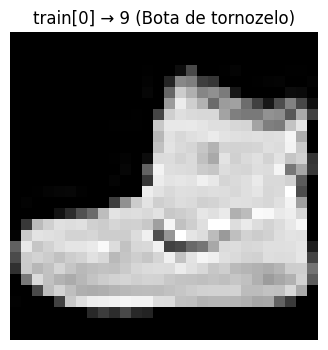

In [11]:
mostrar_imagem(split="train", index=0)

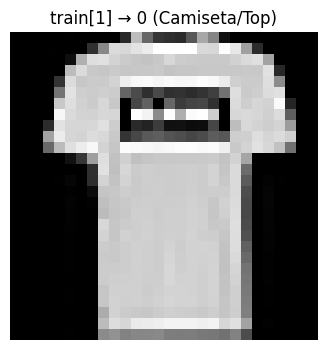

In [12]:
mostrar_imagem(split="train", index=1)

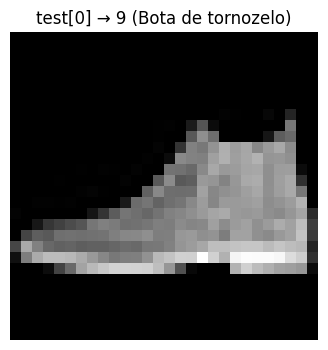

In [13]:
mostrar_imagem(split="test", index=0)

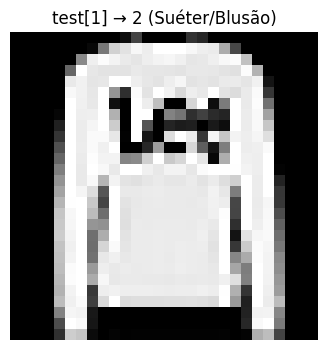

In [14]:
mostrar_imagem(split="test", index=1)

In [15]:
base_dir = "/content/FashionMNIST_data"
batch_size = 128
img_size = (28, 28)
input_shape = img_size + (1,)

In [16]:
datagen = ImageDataGenerator(rescale=1/255.0)

In [17]:
train_gen = datagen.flow_from_directory(
    directory=os.path.join(base_dir, "train"),
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=True
)

Found 60000 images belonging to 10 classes.


In [18]:
test_gen = datagen.flow_from_directory(
    directory=os.path.join(base_dir, "test"),
    target_size=img_size,
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False
)

Found 10000 images belonging to 10 classes.


In [19]:
inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2)(x)

x = layers.Flatten()(x)
features = layers.Dense(128, activation=None, name="features")(x)
x = layers.Activation("relu")(features)
outputs = layers.Dense(10, activation="softmax")(x)

classifier = models.Model(inputs, outputs, name="cnn_classifier")
encoder    = models.Model(inputs, features, name="cnn_encoder")

In [20]:
classifier.summary()

Model: "cnn_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
encoder.summary()

Model: "cnn_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 128)            │       147,584 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,256 (938.50 KB)

 Trainable params: 240,256 (938.50 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
classifier.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [24]:
history = classifier.fit(
    train_gen,
    epochs=50,
    validation_data=test_gen,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 ━━━━━━━━━━━━━━━━━━━━ 104s 219ms/step - accuracy: 0.7015 - loss: 0.8162 - val_accuracy: 0.8543 - val_loss: 0.4005
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 97s 207ms/step - accuracy: 0.8743 - loss: 0.3455 - val_accuracy: 0.8765 - val_loss: 0.3317
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 208ms/step - accuracy: 0.8949 - loss: 0.2883 - val_accuracy: 0.8980 - val_loss: 0.2846
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 212ms/step - accuracy: 0.9123 - loss: 0.2441 - val_accuracy: 0.9000 - val_loss: 0.2775
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 100s 214ms/step - accuracy: 0.9202 - loss: 0.2210 - val_accuracy: 0.9009 - val_loss: 0.2810
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 99s 211ms/step - accuracy: 0.9273 - loss: 0.2005 - val_accuracy: 0.9089 - val_loss: 0.2574
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 210ms/step - accuracy: 0.9332 - loss: 0.1822 - val_accuracy: 0.9107 - val_loss: 0.2480
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 98s 210ms/step - accuracy: 0.9410 - loss: 0.1624 - v

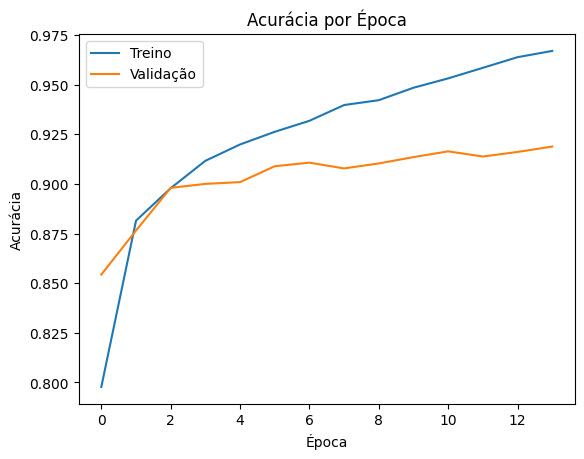

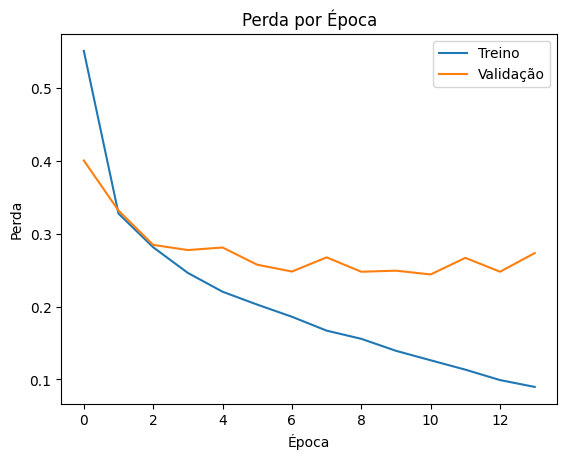

In [25]:
plt.figure()
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda por Época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [26]:
embeddings_test = encoder.predict(test_gen, verbose=1)
labels_test     = test_gen.classes

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


In [30]:
from sklearn.metrics.pairwise import cosine_similarity

embeddings_test = encoder.predict(test_gen, verbose=1)
embeddings_train = encoder.predict(train_gen, verbose=1)

sim = cosine_similarity(
    embeddings_test[0].reshape(1, -1),
    embeddings_train
).flatten()
top5_idx = np.argsort(sim)[-5:][::-1]

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step


In [31]:
train_paths = [os.path.join(train_gen.directory, f) for f in train_gen.filenames]
test_paths = [os.path.join(test_gen.directory, f) for f in test_gen.filenames]
query_path = test_paths[0]

In [33]:
def carregar_imagem(path):
    img = plt.imread(path)
    return img

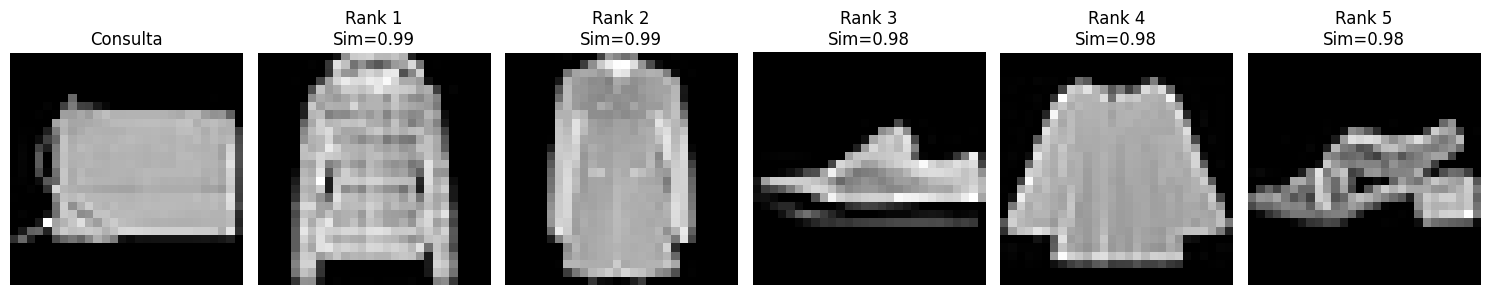

In [34]:
imgs = [carregar_imagem(query_path)] + [carregar_imagem(train_paths[i]) for i in top5_idx]
titles = ["Consulta"] + [f"Rank {i+1}\nSim={sim[idx]:.2f}" for i, idx in enumerate(top5_idx)]

plt.figure(figsize=(15, 5))
for i, (img, title) in enumerate(zip(imgs, titles)):
    ax = plt.subplot(1, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()